In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
class Euler_Maruyama_Simulator:
    def __init__(
            self, funcs,
            y_init = 0, grid_points = 1000,
            t_init = 0, t_end = 10
        ):
        self.a = funcs[0]
        self.b = funcs[1]
        
        self.t_init = t_init
        self.t_end = t_end
        self.y_init = y_init
        self.N = grid_points
        self.dt = float(t_end - t_init) / self.N
        
        self.ts = np.arange(t_init, t_end + self.dt, self.dt)
        
    def dW(delta_t):
        return np.random.normal(scale=np.sqrt(delta_t))
    
    def simulate(self):
        ys = np.zeros(self.ts.size)
        ys[0] = self.y_init
        
        t = self.t_init
        dt = self.dt
        for i in range(1, self.ts.size):
            t = t + dt
            y = ys[i-1]
            ys[i] = y + \
                    self.a(y, t) * dt + \
                    self.b(y, t) * Euler_Maruyama_Simulator.dW(dt)
        return ys
    
    def get_ts(self):
        return copy.copy(self.ts)

In [123]:
def simulations_viewer(num_sims, simulator, show_log=False):    
    ts = simulator.get_ts()
    N = ts.shape[0]
    
    sims = np.ndarray((num_sims, N))
    for i in range(num_sims):
        ys = simulator.simulate()
        sims[i] = ys
        plt.plot(ts, ys)

    plt.xlabel("time (s)")
    if show_log:
        plt.yscale('log')
        
    h = plt.ylabel("y")
    h.set_rotation(0)
    plt.show()
    
    return sims

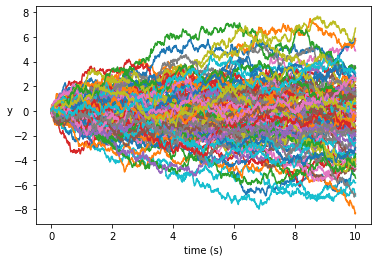

In [4]:
def Brownian_funcs():
    def a(y, t):
        return 0
    def b(y, t):
        return 1
    
    return a, b
    
em_brownian = Euler_Maruyama_Simulator(Brownian_funcs())
simulations_viewer(100, em_brownian)

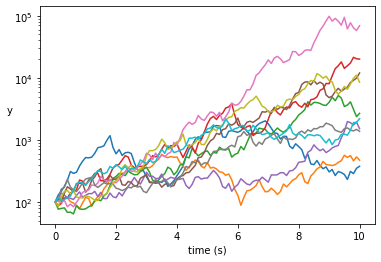

In [5]:
def Geometric_Brownian_funcs(mu, sigma):
    def a(y, t):
        return mu * y
    def b(y, t):
        return sigma * y
    
    return a, b

em_geometirc_brownian = Euler_Maruyama_Simulator(
        Geometric_Brownian_funcs(0.5, 0.5), 
        y_init=100, t_end = 10, grid_points=100
    )
simulations_viewer(10, em_geometirc_brownian, show_log=True)

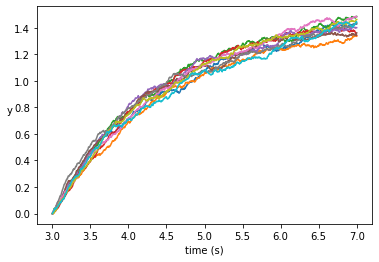

In [6]:
def Ornstein_Uhlenbeck_funcs(theta, mu, sigma):
    def a(y, t):
        return theta * (mu - y)
    def b(y, t):
        return sigma
    
    return a, b

ornstein_unlenbeck_process = Euler_Maruyama_Simulator(
        Ornstein_Uhlenbeck_funcs(0.7, 1.5, 0.06),
        t_init = 3, t_end = 7, y_init = 0,
        grid_points = 1000
    )
simulations_viewer(10, ornstein_unlenbeck_process)

In [116]:
class Fractional_Gaussian_Simulator:
    def __init__(self, H):
        self.h = H
        self.rho = [1]
        
    def __generate_rho_till(self, n):
        H = 2 * self.h
        for i in range(len(self.rho), n):
            self.rho.append(
                ((i+1)**H + (i-1)**H - 2*(i**H)) / 2
            )
            
    def get_cov(self, n):
        cov = np.ndarray((n, n))
        self.__generate_rho_till(n)
        for ind, r in enumerate(self.rho):
            np.fill_diagonal(cov[ind:], r)
            np.fill_diagonal(cov[:, ind:], r)
        return cov
    
    def simulate(self, n):
        cov = np.ndarray((n, n))
        self.__generate_rho_till(n)
        for ind, r in enumerate(self.rho):
            np.fill_diagonal(cov[ind:], r)
            np.fill_diagonal(cov[:, ind:], r)
            
        result = np.random.multivariate_normal(np.zeros(n), cov, 
                    check_valid='ignore')
        return result
    
class Fractional_Brownian_Simulator:
    def __init__(
            self, H, 
            y_init = 0, grid_points = 1000,
            t_init = 0, t_end = 10
        ):
        self.h = H
        
        self.t_init = t_init
        self.t_end = t_end
        self.y_init = y_init
        self.N = grid_points
        self.dt = float(t_end - t_init) / self.N
        self.factor = ((t_end - t_init) / self.N) ** H
        
        self.ts = np.arange(t_init, t_end + self.dt, self.dt)
        self.fGn = Fractional_Gaussian_Simulator(H)
    
    def simulate(self):
        ys = self.fGn.simulate(self.N)
        ys = ys * self.factor
        ys = np.insert(ys, 0, self.y_init)
        ys = np.cumsum(ys)
        
        return ys
    
    def get_ts(self):
        return copy.copy(self.ts)

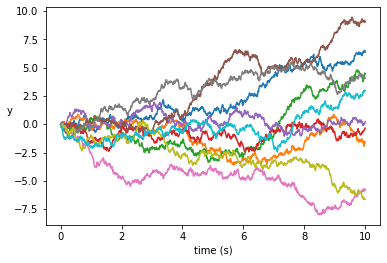

In [8]:
fBm = Fractional_Brownian_Simulator(0.5)
simulations_viewer(10, fBm)

- Find statistics of the sample path
- Check covariance
- Estimate the heurst parameter
- Compare the complexity of implementations

Estimating Heurst Parameter

SIMULATION AND IDENTIFICATION OF THE FRACTIONAL BROWNIAN MOTION: A BIBLIOGRAPHICAL AND COMPARATIVE STUDY section 4.2.1

In [76]:
from scipy import stats

class FBM_Heurst_Estimator:
    @staticmethod
    def get_periodogram(time_series):
        N = time_series.size
        e = np.exp(-1j * np.arange(N))
        
        freq = np.arange(0, N+1) * 2 * np.pi / N
        def func(ind):
            r = np.power(e, ind)
            r = np.dot(time_series, r)
            r = np.power(np.absolute(r), 2)
            return r / (2 * np.pi * N)
        r = np.vectorize(func)(freq)
        return freq, r
    
    @staticmethod
    def log_pgm_method(fbm):
        fgn = fbm[1:] - fbm[:-1]
        freq, pgm = FBM_Heurst_Estimator.get_periodogram(fgn)
        
        lfreq = np.log(freq[1:-1])
        lpgm = np.log(pgm[1:-1])
        
        s, _, _, _, _ = stats.linregress(lfreq, lpgm)
        return (1 - s) / 2
    
    @staticmethod
    def empiric_var_method(fbm):
        N = fbm.size - 1
        
        vd = fbm[2:] - fbm[1:-1]
        vd = np.sum(np.power(vd, 2)) / (N-1)
        
        vd2 = fbm[3:] - fbm[1:-2]
        vd2 = np.sum(np.power(vd2, 2)) / (N-2)
        
        return np.log(vd2 / vd) / (2 * np.log(2))

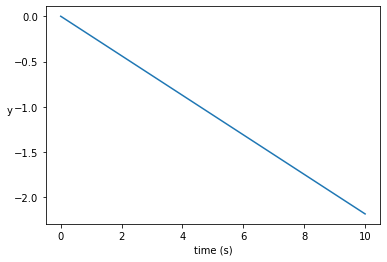

In [96]:
fBm = Fractional_Brownian_Simulator(1)
ys = fBm.simulate()

plt.plot(fBm.get_ts(), ys)
plt.xlabel("time (s)")
h = plt.ylabel("y")
h.set_rotation(0)
plt.show()

In [97]:
FBM_Heurst_Estimator.empiric_var_method(ys)

0.9999999978033457

Covariance Testing

ON HYPOTHESIS TESTS FOR COVARIANCE MATRICES UNDER MULTIVARIATE NORMALITY section 2.1

In [146]:
def hyp_test(test_stat, accept_func):
    if accept_func:
        print("Accept Null Hypothesis (H_0)")
    else:
        print("Reject Null Hypothesis, accept alternative hypothesis (H_1)")

def cov_matrix_lrt_stat(X, cov0, mean=None):
    n = X.shape[0]
    
    if mean is not None:
        known_mean = True
    else:
        known_mean = False
        mean = np.mean(X, axis=0)
        
    centralisedX = X - mean
    A = np.apply_along_axis(lambda x: np.outer(x,x), 1, centralisedX)
    A = np.sum(A, axis=0)
    
    p = A.shape[0]
    cov0_inv = np.linalg.inv(cov0)
    
    result = -p*n
    
    if known_mean:
        est = A / n
        c = cov0_inv.dot(est)
        
        
        print(np.linalg.det(cov0_inv.dot(est)))
        result = result - \
                n*np.log(np.linalg.det(cov0_inv.dot(est))) + \
                n*np.trace(cov0_inv.dot(est))
    else:
        result = result + p*n*np.log(n) - \
                n*np.log(np.linalg.det(A.dot(cov0_inv))) + \
                np.trace(cov0_inv.dot(A))
        
    return result

def cov_matrix_lrt_accept(sig_level, p):
    def f(v):
        u = stats.chi2(sig_level, p * (p+1) // 2)
        return v <= u
    return f

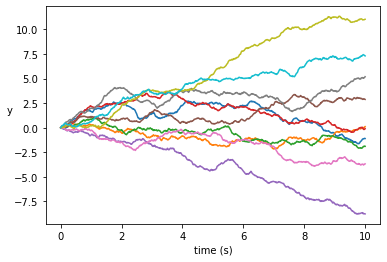

[[ 0.56366261  0.26511163 -0.04688433 ...  0.06441947  0.16603719
  -0.15126044]
 [ 0.43918179  0.83900159  0.26329022 ... -0.23197558 -0.30915943
  -0.44444329]
 [-0.05215353  0.11829053  0.57108777 ... -0.05197064 -0.48893366
   0.13878607]
 ...
 [ 0.08586362  0.01743837  0.20060694 ...  0.14986993 -0.33347191
  -0.13988644]
 [ 0.14596323 -0.19939507 -0.54551942 ...  0.01179648  0.76361039
   0.14270584]
 [-0.20127141 -0.2299179   0.31475899 ...  0.11514179  0.23527047
   1.08314312]]
-0.0
Accept Null Hypothesis (H_0)


/Users/chesterwong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


In [147]:
H = 0.75
sig_level = 0.95

fGn = Fractional_Gaussian_Simulator(H)
fBm = Fractional_Brownian_Simulator(H)
fBms = simulations_viewer(10, fBm)

fGns = fBms[:,1:] - fBms[:,:-1]
p = fGns.shape[1]
cov = fGn.get_cov(p) * fBm.factor ** 2

stat = cov_matrix_lrt_stat(fGns, cov, mean=np.zeros(p))
hyp_test(stat, cov_matrix_lrt_accept(sig_level, p))

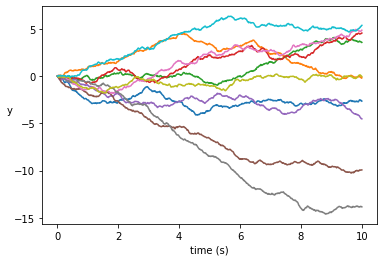

In [124]:
H = 0.75
sig_level = 0.95

fGn = Fractional_Gaussian_Simulator(H)
fBm = Fractional_Brownian_Simulator(H)
fBms = simulations_viewer(10, fBm)

In [128]:
print((fBms[:,1:] - fBms[:,:-1]).shape)

(10, 1000)
